#### Setup and Data Loading

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import warnings
import sqlite3 
import mysql.connector
from dotenv import load_dotenv
import os

# Suppress minor warnings for a clean output
warnings.filterwarnings('ignore', category=UserWarning)

# Load environment variables for potential future direct MySQL access, though we rely on CSVs now
load_dotenv()
MYSQL_USER = os.getenv('MYSQL_USER')

# Data Loading
try:
    # Load pre-calculated summaries from Phase 2
    location_summary = pd.read_csv('location_summary.csv', index_col='location')
    significance_results = pd.read_csv('significance_results.csv')

    # We will use the SQL connector to read the data for a professional demo
    conn = mysql.connector.connect(
        user=os.getenv('MYSQL_USER'),
        password=os.getenv('MYSQL_PASSWORD'),
        host=os.getenv('MYSQL_HOST'),
        database=os.getenv('MYSQL_DATABASE')
    )
    df_full = pd.read_sql("SELECT * FROM gts_processed_data WHERE is_valid = 1;", conn)
    conn.close()
    
    # Ensure scores are integers
    score_cols = ['aid_satisfaction', 'trust_in_aid_provider', 'communication_clarity', 'aid_fairness']
    for col in score_cols:
        df_full[col] = df_full[col].astype(int)

    print(f"Analysis results and full clean data ({len(df_full)} records) loaded successfully for plotting.")

except FileNotFoundError:
    print("ERROR: Missing analysis results (CSV files). Please run Phase 2 first.")
    # Create empty dataframes to prevent crashes
    location_summary = pd.DataFrame()
    significance_results = pd.DataFrame()
except mysql.connector.Error as err:
    print(f"MySQL Error during data retrieval: {err}")
    df_full = pd.DataFrame() 

if df_full.empty or location_summary.empty:
    raise RuntimeError("Cannot proceed with visualization as data loading failed.")

Analysis results and full clean data (8091 records) loaded successfully for plotting.


#### Visualization 1 - Diverging Stacked Bar Chart

Generated Visualization 1: Diverging Stacked Bar Chart.


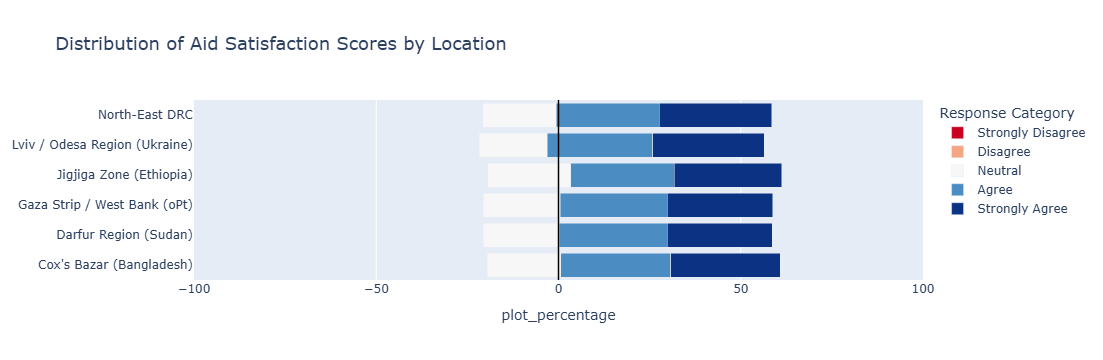

In [3]:
def plot_sentiment_divergence(df):
    # Mapping sentiment categories and colors
    sentiment_map = {1: 'Strongly Disagree', 2: 'Disagree', 3: 'Neutral', 4: 'Agree', 5: 'Strongly Agree'}
    color_map = {
        'Strongly Disagree': 'rgb(202, 0, 32)',    # Deep Red (Detractor)
        'Disagree': 'rgb(244, 165, 130)',          # Light Red/Orange (Detractor)
        'Neutral': 'rgb(247, 247, 247)',           # White/Grey (Neutral)
        'Agree': 'rgb(75, 141, 195)',              # Blue (Promoter)
        'Strongly Agree': 'rgb(12, 51, 131)'       # Deep Blue (Promoter)
    }
    
    # Calculate percentage of responses per location and sentiment
    df_plot = df.groupby(['location', 'aid_satisfaction']).size().reset_index(name='count')
    df_plot['sentiment'] = df_plot['aid_satisfaction'].map(sentiment_map)
    df_plot['percentage'] = df_plot.groupby('location')['count'].transform(lambda x: 100 * x / x.sum())
    
    # Assign negative values to Detractors (1 and 2) for divergence
    df_plot['plot_percentage'] = df_plot.apply(
        lambda row: row['percentage'] if row['aid_satisfaction'] >= 3 else -row['percentage'], axis=1
    )

    fig = px.bar(
        df_plot, y='location', x='plot_percentage', color='sentiment', orientation='h',
        color_discrete_map=color_map,
        category_orders={'sentiment': list(sentiment_map.values())},
        title='Distribution of Aid Satisfaction Scores by Location'
    )

    # Customization for divergence
    fig.update_layout(
        xaxis_range=[-100, 100], 
        xaxis_tickformat=',.0f%', 
        yaxis_title=None, 
        legend_title='Response Category',
        barmode='stack',
        title_font_size=18
    )

    # Add central dividing line
    fig.add_vline(x=0, line_width=1.5, line_dash="solid", line_color="black")

    print("Generated Visualization 1: Diverging Stacked Bar Chart.")
    return fig

fig_sentiment = plot_sentiment_divergence(df_full)
fig_sentiment.show()

#### Visualization 2: Interactive Geospatial Map (Trust Hotspots)

Generated Visualization 2: Geospatial Hotspot Map (Trust).


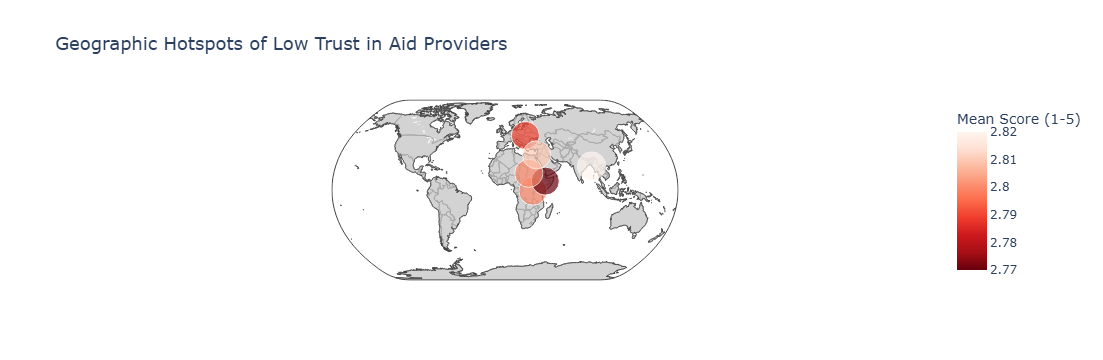

In [4]:
def plot_trust_hotspots(df_summary):
    # Prepare data for map plotting (reading location names from the index)
    df_map = df_summary.reset_index()[['location', 'trust_in_aid_provider']]
    df_map.rename(columns={'trust_in_aid_provider': 'Mean_Trust_Score'}, inplace=True)
    
    # Assign dummy coordinates for Plotly to render the points geographically.
    # NOTE: This uses hardcoded, illustrative coordinates. In a real project, this would use a GeoJSON join.
    location_coords = {
        'Darfur Region (Sudan)': [15.0, 25.0], 'Gaza Strip / West Bank (oPt)': [31.5, 34.5], 
        'Jigjiga Zone (Ethiopia)': [8.0, 42.0], 'North-East DRC': [-1.0, 29.0], 
        'Lviv / Odesa Region (Ukraine)': [49.0, 24.0], "Cox's Bazar (Bangladesh)": [21.5, 92.0]
    }
    df_map['lat'] = df_map['location'].apply(lambda x: location_coords.get(x, [0, 0])[0])
    df_map['lon'] = df_map['location'].apply(lambda x: location_coords.get(x, [0, 0])[1])

    # Create the map
    fig = px.scatter_geo(
        df_map,
        lat='lat',
        lon='lon',
        hover_name='location',
        color='Mean_Trust_Score', # Color intensity by mean score
        size='Mean_Trust_Score',  # Size by mean score 
        projection='natural earth',
        color_continuous_scale=px.colors.sequential.Reds_r, # Reverse red scale: low score = bright red
        title='Geographic Hotspots of Low Trust in Aid Providers'
    )

    fig.update_layout(
        coloraxis_colorbar=dict(title="Mean Score (1-5)"),
        title_font_size=18
    )

    fig.update_geos(
        showland=True, landcolor="lightgray", showcountries=True, 
        countrycolor="darkgray"
    )

    print("Generated Visualization 2: Geospatial Hotspot Map (Trust).")
    return fig

fig_map = plot_trust_hotspots(location_summary)
fig_map.show()

#### Visualization 3: Statistical Comparison Chart (T-Test Results)

Generated Visualization 3: Statistical Comparison Chart.


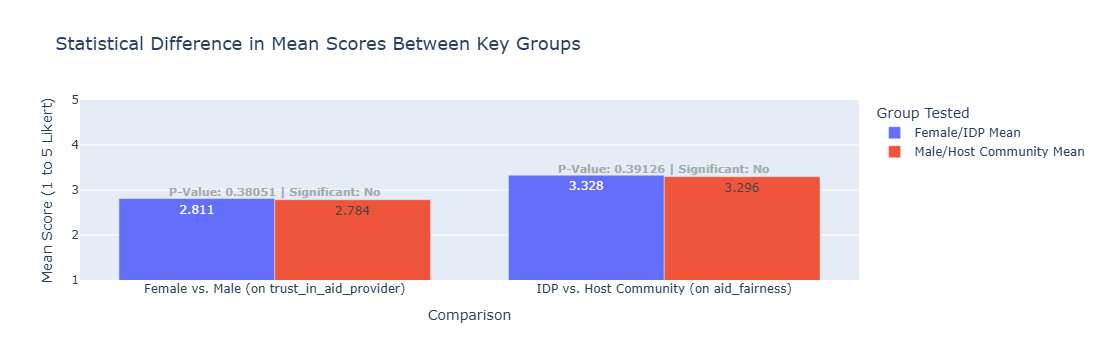

In [5]:
def plot_ttest_comparison(ttest_df):
    # 1. Prepare data for plotting
    ttest_df['Annotation'] = ttest_df.apply(
        lambda row: f"P-Value: {row['P_Value']} | Significant: {row['Significance']}", axis=1
    )
    
    # Convert to long format for Plotly bar chart
    ttest_df_long = pd.melt(
        ttest_df, id_vars=['Comparison', 'Annotation', 'Significance'], 
        value_vars=['Mean_G1', 'Mean_G2'], var_name='Group_Code', value_name='Mean_Score'
    )
    
    # Clean up group names
    ttest_df_long['Group_Name'] = ttest_df_long.apply(
        lambda row: 'Female/IDP Mean' if row['Group_Code'] == 'Mean_G1' else 
                    'Male/Host Community Mean', axis=1
    )

    # 2. Create the bar chart
    fig = px.bar(
        ttest_df_long, x='Comparison', y='Mean_Score', color='Group_Name', barmode='group',
        text_auto='.3f', title='Statistical Difference in Mean Scores Between Key Groups'
    )

    # 3. Add significance annotations
    for i, row in ttest_df.iterrows():
        max_score = max(row['Mean_G1'], row['Mean_G2'])
        
        fig.add_annotation(
            x=row['Comparison'], 
            y=max_score + 0.15, 
            text=row['Annotation'],
            showarrow=False,
            font=dict(
                size=11,
                color='darkred' if row['Significance'] == 'Yes' else 'darkgray', # Highlight significant results
                weight='bold'
            )
        )

    fig.update_layout(
        yaxis_range=[1, 5], 
        yaxis_title='Mean Score (1 to 5 Likert)',
        legend_title='Group Tested',
        title_font_size=18
    )
    
    print("Generated Visualization 3: Statistical Comparison Chart.")
    return fig

fig_ttest = plot_ttest_comparison(significance_results)
fig_ttest.show()